Points of difference:
- When threshold is initialized as ones/Vt (like in matlab) instead of zeros, there are no waves, only when initialized as zeros (unlike matlab code).

- Learning rule (solving weight matrix dynamical system) in Matlab takes input as spiked and output y variable of the layer. Instead here, we use Signals of presynaptic and postsynaptic activity from Nengo.

- Did not include line from matlab code for solving W1 matrix dynamical system : W1(:,fireL) = 10*(W1(:,fireL))./range(W1(:,fireL),1);

- Here voltage is rectified to a floor of zero unlike in matlab. When voltage is not rectified the voltage dynamics change greatly from spike-like to almost a monotonic decrease. Waves and threshold do not change much, however.



In [488]:
# Custom Learning Rule
# Subclass of LearningRuleType

import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.spatial.distance import pdist, squareform
from IPython.display import clear_output
%matplotlib inline

import nengo
from nengo.rc import rc
from nengo.params import Parameter, NumberParam, NdarrayParam, Default
from nengo.neurons import settled_firingrate, LIFRate 
from nengo.builder.operator import Operator, Copy
from nengo.builder import Builder
from nengo.builder.signal import Signal
from nengo.synapses import Lowpass, SynapseParam
from nengo.builder.learning_rules import get_pre_ens, get_post_ens, build_or_passthrough


class STDP(nengo.learning_rules.LearningRuleType):
    """STDP Hebbian learning rule.
    Modifies connection weights according to the Hebbian STDP rule.
    Notes
    -----
    The rule is dependent on pre and post neural activities,
    not decoded values, and so is not affected by changes in the
    size of pre and post ensembles. However, if you are decoding from
    the post ensemble, the Oja rule will have an increased effect on
    larger post ensembles because more connection weights are changing.
    In these cases, it may be advantageous to scale the learning rate
    on the rule by ``1 / post.n_neurons``.
    Parameters
    ----------
    learning_rate : float, optional
        A scalar indicating the rate at which weights will be adjusted.
    pre_synapse : `.Synapse`, optional
        Synapse model used to filter the pre-synaptic activities.
    post_synapse : `.Synapse`, optional
        Synapse model used to filter the post-synaptic activities.
        If None, ``post_synapse`` will be the same as ``pre_synapse``.
    Attributes
    ----------
    learning_rate : float
    A scalar indicating the rate at which weights will be adjusted.
    post_synapse : `.Synapse`
        Synapse model used to filter the post-synaptic activities.
    pre_synapse : `.Synapse`
        Synapse model used to filter the pre-synaptic activities.
    """

    modifies = "weights"
    probeable = ("pre_filtered", "post_filtered", "delta")

    learning_rate = NumberParam("learning_rate", low=0, readonly=True, default=1)
    pre_synapse = SynapseParam("pre_synapse", default=Lowpass(tau=0.005), readonly=True)
    post_synapse = SynapseParam("post_synapse", default=None, readonly=True)

    def __init__(
        self,
        learning_rate=Default,
        pre_synapse=Default,
        post_synapse=Default,
    ):
        super().__init__(learning_rate, size_in=0)

        self.pre_synapse = pre_synapse
        self.post_synapse = (
            self.pre_synapse if post_synapse is Default else post_synapse
        )

    @property
    def _argreprs(self):
        return _remove_default_post_synapse(super()._argreprs, self.pre_synapse)
    

    
# Simulator Operator that implements learning rule

class SimSTDP(Operator):
    r"""Calculate connection weight change according to the STDP Hebbian rule.
    Implements the Hebbian learning rule of the form
    .. math:: \Delta \omega_{ij} = \kappa (a_i a_j)
    where
    * :math:`\kappa` is a scalar learning rate,
    * :math:`a_i` is the activity of a presynaptic neuron,
    * :math:`a_j` is the activity of a postsynaptic neuron,
    Parameters
    ----------
    pre_filtered : Signal
        The presynaptic activity, :math:`a_i`.
    post_filtered : Signal
        The postsynaptic activity, :math:`a_j`.
    delta : Signal
        The synaptic weight change to be applied, :math:`\Delta \omega_{ij}`.
    learning_rate : float
        The scalar learning rate, :math:`\kappa`.
    tag : str, optional
        A label associated with the operator, for debugging purposes.
    Attributes
    ----------
    delta : Signal
        The synaptic weight change to be applied, :math:`\Delta \omega_{ij}`.
    learning_rate : float
        The scalar learning rate, :math:`\kappa`.
    post_filtered : Signal
        The postsynaptic activity, :math:`a_j`.
    pre_filtered : Signal
        The presynaptic activity, :math:`a_i`.
    tag : str or None
        A label associated with the operator, for debugging purposes.
    Notes
    -----
    1. sets ``[]``
    2. incs ``[]``
    3. reads ``[pre_filtered, post_filtered, weights]``
    4. updates ``[delta]``
    """

    def __init__(
        self, pre_filtered, post_filtered, delta, learning_rate, tag=None
    ):
        super().__init__(tag=tag)
        self.learning_rate = learning_rate

        self.sets = []
        self.incs = []
        self.reads = [pre_filtered, post_filtered]
        self.updates = [delta]

    @property
    def delta(self):
        return self.updates[0]

    @property
    def pre_filtered(self):
        return self.reads[0]

    @property
    def post_filtered(self):
        return self.reads[1]

    @property
    def _descstr(self):
        return "pre=%s, post=%s -> %s" % (
            self.pre_filtered,
            self.post_filtered,
            self.delta,
        )

    def make_step(self, signals, dt, rng):
        pre_filtered = signals[self.pre_filtered]
        post_filtered = signals[self.post_filtered]
        delta = signals[self.delta]
        alpha = self.learning_rate * dt

        def step_simSTDP():
            # perform update
            delta[...] += alpha* np.outer(post_filtered, pre_filtered)

        return step_simSTDP
    
    
# Build function for new learning type

@Builder.register(STDP)
def build_STDP(model, STDP, rule):
    """Builds a `.STDP` object into a model.
    Calls synapse build functions to filter the pre and post activities,
    and adds a `.SimSTDP` operator to the model to calculate the delta.
    Parameters
    ----------
    model : Model
        The model to build into.
    STDP : STDP
        Learning rule type to build.
    rule : LearningRule
        The learning rule object corresponding to the neuron type.
    Notes
    -----
    Does not modify ``model.params[]`` and can therefore be called
    more than once with the same `.Oja` instance.
    """

    conn = rule.connection
    pre_activities = model.sig[get_pre_ens(conn).neurons]["out"]
    post_activities = model.sig[get_post_ens(conn).neurons]["out"]
    pre_filtered = build_or_passthrough(model, STDP.pre_synapse, pre_activities)
    post_filtered = build_or_passthrough(model, STDP.post_synapse, post_activities)

    model.add_op(
        SimSTDP(
            pre_filtered,
            post_filtered,
            model.sig[rule]["delta"],
            learning_rate=STDP.learning_rate,
        )
    )

    # expose these for probes
    model.sig[rule]["pre_filtered"] = pre_filtered
    model.sig[rule]["post_filtered"] = post_filtered

In [489]:
# Custom LIF Neuron Type
# Frontend Neurons subclass
class CustomLIF(nengo.neurons.NeuronType):
    """Spiking version of the leaky integrate-and-fire (LIF) neuron model.

    Parameters
    ----------
    tau_rc : float
        Membrane RC time constant, in seconds. Affects how quickly the membrane
        voltage decays to zero in the absence of input (larger = slower decay).
    min_voltage : float
        Minimum value for the membrane voltage. If ``-np.inf``, the voltage
        is never clipped.
    num : int
        Number of neurons in the layer.
    S : ndarray
        Intra-layer adjacency matrix.
    tau_th : int
    th_plus : int
        Rate by which threshold increases whenever a neuron is spiking
    v_th : int
        Default threshold
    v_reset : ndarray
    nx : ndarray
    fnoise : ndarray
    
    """

    probeable = ("spikes", "voltage", "threshold")
    
    def __init__(
        self, 
        S, 
        num, 
        tau_rc, 
        tau_th,
        th_plus,
        v_th,
        v_reset,
        nx,
        fnoise,
        thresh,
        min_voltage=0, 
        step=0
    ):
        super().__init__()
        self.tau_rc=tau_rc
        self.min_voltage=min_voltage
        self.num=num
        self.S=S
        self.nx=nx
        self.tau_th=tau_th
        self.th_plus=th_plus
        self.v_th=v_th
        self.v_reset=v_reset
        self.fnoise=fnoise
        self.thresh=thresh
        self.step=step

    def gain_bias(self, max_rates, intercepts):
        """Set gain and bias."""
        gain = np.ones((self.num,))
        bias = np.zeros((self.num,))
        return gain, bias

    def rates(self, x, gain, bias):
        """Estimates steady-state firing rate given gain and bias."""
        J = self.current(x, gain, bias)
        voltage = np.zeros_like(J)
        threshold = np.zeros_like(J)
        return settled_firingrate(
            self.step_math, J, [voltage, threshold], settle_time=0.001, sim_time=1.0
        )

    def step_math(self, dt, J, spiked, voltage, threshold): 
#         voltage = np.maximum(-350, voltage)

        H = spiked * dt
        if self.num == nR:
            U = np.matmul(H, self.S)
            eta = self.fnoise[:,self.step]
            dV = (1/self.tau_rc) * (-1*voltage + U + eta)
            voltage[:] += dV * dt * 100
#             print('final voltage = {}'.format(voltage))

        elif self.num == nL:
            # Inputs to LGN: Weights -> Activation function -> Competition rule
            x = np.maximum(J - self.thresh, 0) 
            win, maxInd = np.max(x), np.argmax(x) #maxk doesn't exist in python
            
            # LGN competition rule
            x[x < win] = 0 # only allow winner to participate (make all other entries 0)
            U = np.matmul(H, self.S) + x
            dV = 1/self.tau_rc*(-1*voltage + U)
            voltage[:] += dV * dt * 100

            # update thresh
            self.thresh += 0.01 * x * dt
            
        # step threshold voltage (theta)
        dTh = (1/self.tau_th)*(self.v_th-threshold)*(1-H)+self.th_plus*H
        threshold[:] += dTh * dt * 100
        # determine which neurons spiked (set spiked voltages to v_reset)
        spiked_mask = voltage > threshold
        spiked[:] = spiked_mask / dt
        voltage[spiked_mask] = self.v_reset[spiked_mask]

        self.step += 1
        
        
# Backend Operator subclass
class SimCustomLIF(Operator):
    """Set a neuron model output for the given input current.

    Implements ``neurons.step_math(dt, J, output, *states)``.

    Parameters
    ----------
    neurons : NeuronType
        The `.NeuronType`, which defines a ``step_math`` function.
    J : Signal
        The input current.
    output : Signal
        The neuron output signal that will be set.
    states : list, optional
        A list of additional neuron state signals set by ``step_math``.
    tag : str, optional
        A label associated with the operator, for debugging purposes.

    Attributes
    ----------
    J : Signal
        The input current.
    neurons : NeuronType
        The `.NeuronType`, which defines a ``step_math`` function.
    output : Signal
        The neuron output signal that will be set.
    states : list
        A list of additional neuron state signals set by ``step_math``.
    tag : str or None
        A label associated with the operator, for debugging purposes.

    Notes
    -----
    1. sets ``[output] + states``
    2. incs ``[]``
    3. reads ``[J]``
    4. updates ``[]``
    """
    
    def __init__(self, neurons, J, output, states=None, tag=None):
        super().__init__(tag=tag)
        self.neurons = neurons

        self.sets = [output] + ([] if states is None else states)
        self.incs = []
        self.reads = [J]
        self.updates = []

    @property
    def J(self):
        return self.reads[0]

    @property
    def output(self):
        return self.sets[0]

    @property
    def states(self):
        return self.sets[1:]

    def _descstr(self):
        return "%s, %s, %s" % (self.neurons, self.J, self.output)

    def make_step(self, signals, dt, rng):
        J = signals[self.J]
        output = signals[self.output]
        states = [signals[state] for state in self.states]

        def step_simcustomlif():
            self.neurons.step_math(dt, J, output, *states)

        return step_simcustomlif
    
    
    

# Build function
@Builder.register(CustomLIF)
def build_customlif(model, neuron_type, neurons):
    """Builds a `.LIF` object into a model.

    In addition to adding a `.SimNeurons` operator, this build function sets up
    signals to track the voltage and refractory times for each neuron.

    Parameters
    ----------
    model : Model
        The model to build into.
    neuron_type : CustomLIF
        Neuron type to build.
    neuron : Neurons
        The neuron population object corresponding to the neuron type.

    Notes
    -----
    Does not modify ``model.params[]`` and can therefore be called
    more than once with the same `.LIF` instance.
    """

    model.sig[neurons]["voltage"] = Signal(
        np.zeros(neurons.size_in, dtype=rc.float_dtype),
        name="%s.voltage" % neurons
    )
    model.sig[neurons]["threshold"] = Signal(
        np.ones(neurons.size_in, dtype=rc.float_dtype),
        name= "%s.threshold" % neurons
    )
    model.add_op(
        SimCustomLIF(
            neurons=neuron_type,
            J=model.sig[neurons]["in"],
            output=model.sig[neurons]["out"],
            states=[
                model.sig[neurons]["voltage"],
                model.sig[neurons]["threshold"]
            ],
        )
    )

In [490]:
# System Constants
nR = 1632      # Num Neurons in Retina
nL = 512       # Num Neurons in LGN
nV = 512       # Num Neurons in V1

# Retina Parameters
ret_thresh = np.zeros((nR,))
ret_v_reset = (0+0.1*(np.random.randn(nR,))**2) * 100 # Noise on activity field
# Spatial Parameters
sqR = 28
ret_nx = sqR*np.random.rand(nR,2)
ret_D = squareform(pdist(ret_nx))
# Adjacency kernel
ret_ri, ret_ro, ret_lam, ret_ai, ret_ao = 3, 6, 10, 30, 10
ret_D = squareform(pdist(ret_nx))     # Non-dimensional distance matrix
ret_S = ret_ai*(ret_D < ret_ri) - ret_ao*(ret_D > ret_ro) * np.exp(-ret_D / ret_lam); 
ret_S = ret_S - np.diag(np.diag(ret_S));    
# Dynamics parameters
ret_tau_v, ret_tau_th, ret_th_plus, ret_v_th = 1, 30, 9, 1


# LGN Parameters
LGN_thresh = np.random.normal(40,2,(nL,))
LGN_v_reset = (0+0.1*(np.random.randn(nL,))**2) * 100 # Noise on activity field
# Spatial Parameters
sqL = 10
LGN_nx = sqL*np.random.rand(nL,2)
LGN_D = squareform(pdist(LGN_nx))
# Adjacency kernel
LGN_ri, LGN_ro, LGN_lam, LGN_ai, LGN_ao = 1.2, 1.5, 10, 30, 10
LGN_D = squareform(pdist(LGN_nx))     # Non-dimensional distance matrix
LGN_S = LGN_ai*(LGN_D < LGN_ri) - LGN_ao*(LGN_D > LGN_ro) * np.exp(-LGN_D / LGN_lam); 
LGN_S = LGN_S - np.diag(np.diag(LGN_S)); 
# Dynamics parameters
LGN_tau_v, LGN_tau_th, LGN_th_plus, LGN_v_th = 1, 20, 12, 1

# V1 Parameters
V1_thresh = np.random.normal(40,2,(nV,))
V1_v_reset = (0+0.1*(np.random.randn(nV,))**2) * 100 # Noise on activity field
# Spatial Parameters
sqV = 10
V1_nx = sqV*np.random.rand(nV,2)
V1_D = squareform(pdist(LGN_nx))
# Adjacency kernel
V1_ri, V1_ro, V1_lam, V1_ai, V1_ao = 1.2, 1.5, 10, 30, 10
V1_D = squareform(pdist(V1_nx))     # Non-dimensional distance matrix
V1_S = V1_ai*(V1_D < V1_ri) - V1_ao*(V1_D > V1_ro) * np.exp(-V1_D / V1_lam); 
V1_S = V1_S - np.diag(np.diag(V1_S)); 
# Dynamics parameters
V1_tau_v, V1_tau_th, V1_th_plus, V1_v_th = 1, 20, 12, 1


# Synaptic Weight Matrix I (Ret-LGN1)
weight = np.ones((512, 1632))
mu_W1 = 2.5
sigma_W1 = 0.14
W1 = np.random.normal(mu_W1, sigma_W1, (nR,nL))
W1 = W1/np.mean(W1, axis = 0) * mu_W1
W1 = np.transpose(W1)

# Synaptic Weight Matrix II (LGN1-V1)
mu_W2 = 2.5
sigma_W2 = 0.14
W2 = np.random.normal(mu_W2, sigma_W2, (nL,nV))
W2 = W2/np.mean(W2, axis = 0) * mu_W2 
W2 = np.transpose(W2)

dt = 0.01
runtime = .8
steps = int(runtime / dt)
ret_fnoise = 3*np.random.randn(nR, steps)
# ret_fnoise = np.transpose(ret_fnoise)
LGN_fnoise = 3*np.zeros((steps, nL))
V1_fnoise = 3*np.zeros((steps, nV))

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

Text(0, 0.5, 'Neuron number')

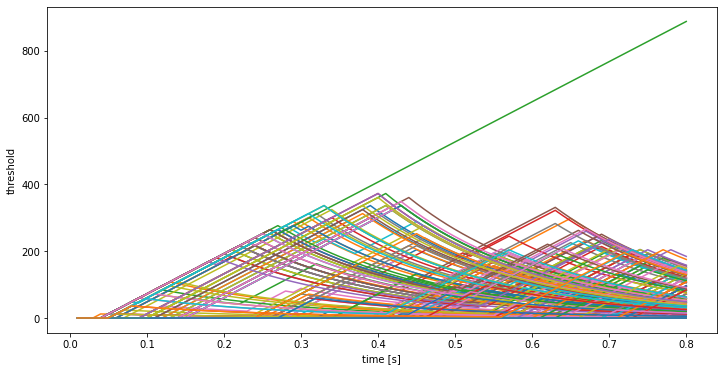

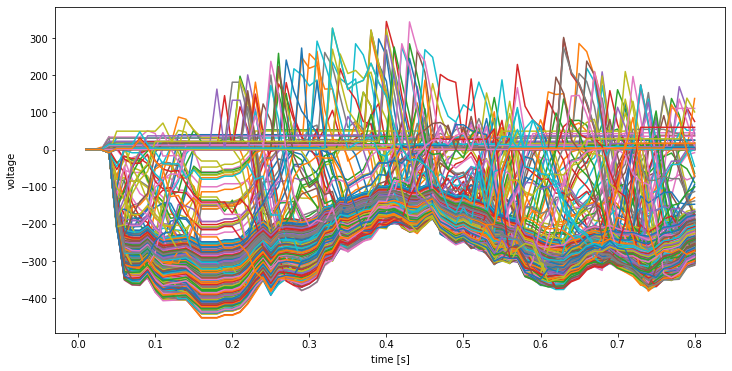

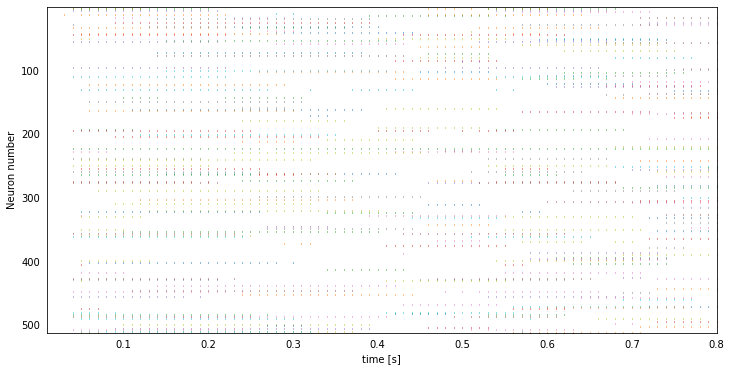

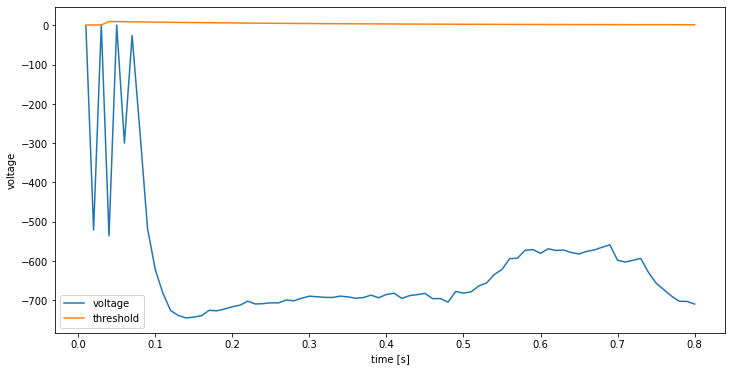

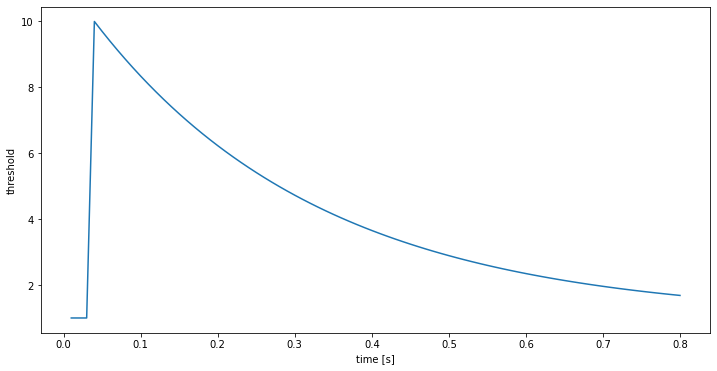

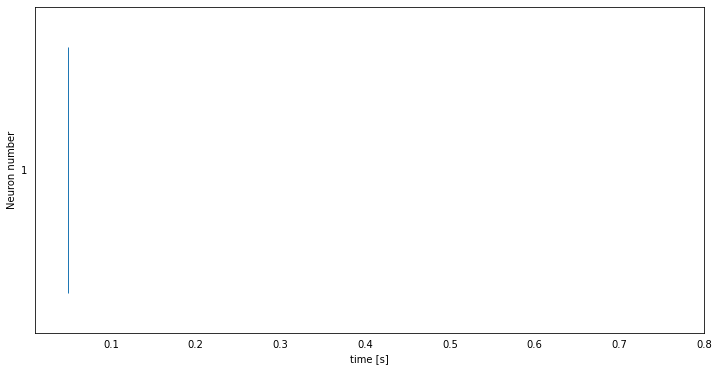

In [491]:
from nengo.utils.matplotlib import rasterplot
# import nengo_loihi

model = nengo.Network()
with model:
    ret = nengo.Ensemble(nR, dimensions=1, neuron_type=CustomLIF(ret_S, nR, ret_tau_v, ret_tau_th, ret_th_plus, 
                                                               ret_v_th, ret_v_reset, ret_nx, ret_fnoise, ret_thresh))
    LGN = nengo.Ensemble(nL, dimensions=1, neuron_type=CustomLIF(LGN_S, nL, LGN_tau_v, LGN_tau_th, LGN_th_plus, 
                                                               LGN_v_th, LGN_v_reset, LGN_nx, LGN_fnoise, LGN_thresh))
    V1 = nengo.Ensemble(nV, dimensions=1, neuron_type=CustomLIF(V1_S, nV, V1_tau_v, V1_tau_th, V1_th_plus, 
                                                               V1_v_th, V1_v_reset, V1_nx, V1_fnoise, V1_thresh))
    
    conn1 = nengo.Connection(ret.neurons, LGN.neurons, transform=W1)
    conn1.learning_rule_type = STDP()
    conn2 = nengo.Connection(LGN.neurons, V1.neurons, transform=W2)
    conn2.learning_rule_type = STDP()


    ret_spikes = nengo.Probe(ret.neurons, 'spikes')
    ret_voltage = nengo.Probe(ret.neurons, 'voltage')
    ret_threshold = nengo.Probe(ret.neurons, 'threshold')

    LGN_spikes = nengo.Probe(LGN.neurons, 'spikes')
    LGN_voltage = nengo.Probe(LGN.neurons, 'voltage')
    LGN_threshold = nengo.Probe(LGN.neurons, 'threshold')
    
    V1_spikes = nengo.Probe(V1.neurons, 'spikes')
    V1_voltage = nengo.Probe(V1.neurons, 'voltage')
    V1_threshold = nengo.Probe(V1.neurons, 'threshold')
    
    weights_p1 = nengo.Probe(conn1, 'weights', synapse=0.01, sample_every=0.01)
    weights_p2 = nengo.Probe(conn2, 'weights', synapse=0.01, sample_every=0.01)



with nengo.Simulator(model, dt = dt) as sim:
# Initialize threshold (voltage and spiked default zero already)
#     sim.signals[sim.model.sig[a.neurons]['threshold']] = np.ones((nR,))/ret_Vt
#     sim.signals[sim.model.sig[b.neurons]['threshold']] = np.ones((nL,))/LGN_Vt

    sim.run(runtime)
    
# Plot dynamics

plt.figure(figsize=(12, 6))
plt.plot(sim.trange(), sim.data[V1_threshold])
plt.xlabel('time [s]')
plt.ylabel('threshold')

plt.figure(figsize=(12, 6))
plt.plot(sim.trange(), sim.data[V1_voltage])
plt.xlabel('time [s]')
plt.ylabel('voltage')

plt.figure(figsize=(12, 6))
rasterplot(sim.trange(), sim.data[V1_spikes])
plt.xlabel('time [s]')
plt.ylabel('Neuron number')


plt.figure(figsize=(12, 6))
plt.plot(sim.trange(), sim.data[ret_voltage][:,500], label="voltage")
plt.plot(sim.trange(), sim.data[ret_threshold][:,500], label="threshold")

plt.xlabel('time [s]')
plt.ylabel('voltage')
plt.legend()


plt.figure(figsize=(12, 6))
plt.plot(sim.trange(), sim.data[ret_threshold][:,500])
plt.xlabel('time [s]')
plt.ylabel('threshold')

plt.figure(figsize=(12, 6))
rasterplot(sim.trange(), sim.data[ret_spikes][0:steps+1,0:1])
plt.xlabel('time [s]')
plt.ylabel('Neuron number')

# print(sim.data[ret_voltage][:,0])

# plt.figure(figsize=(12, 6))
# plt.plot(sim.trange(), sim.data[V1_voltage])
# plt.xlabel('time [s]')
# plt.ylabel('voltage')

# plt.figure(figsize=(12, 6))
# plt.plot(sim.trange(sample_every=0.01), sim.data[weights_p1][..., 10])
# plt.xlabel('time [s]')
# plt.ylabel('Connection weight')

# plt.figure(figsize=(12, 6))
# plt.plot(sim.trange(sample_every=0.01), sim.data[weights_p2][..., 10])
# plt.xlabel('time [s]')
# plt.ylabel('Connection weight')



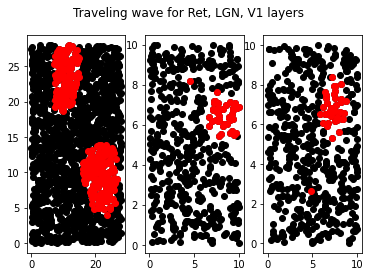

In [492]:
# Visualization of Wave
for t in range(len(sim.trange())):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.suptitle('Traveling wave for Ret, LGN, V1 layers')

    ax1.scatter(ret_nx[:,0], ret_nx[:,1], color = 'k')
    fired = np.argwhere(sim.data[ret_spikes][t,:])
    ax1.scatter(ret_nx[fired,0], ret_nx[fired,1], color = 'r')
    
    ax2.scatter(LGN_nx[:,0], LGN_nx[:,1], color = 'k')
    fired = np.argwhere(sim.data[LGN_spikes][t,:])
    ax2.scatter(LGN_nx[fired,0], LGN_nx[fired,1], color = 'r')
    
    ax3.scatter(V1_nx[:,0], V1_nx[:,1], color = 'k')
    fired = np.argwhere(sim.data[V1_spikes][t,:])
    ax3.scatter(V1_nx[fired,0], V1_nx[fired,1], color = 'r')
    plt.show()
    clear_output(wait=True)